#Predicting housing prices using California Housing Prices (1990)

Dataset from: https://www.kaggle.com/camnugent/california-housing-prices

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

#Data Preparation

In [3]:
df = pd.read_csv('archive\housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
#Filling null values in total_bedrooms with the median value
df['total_bedrooms'].fillna(df['total_bedrooms'].median(),inplace = True)

In [6]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [7]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')
df.dtypes

longitude              float64
latitude               float64
housing_median_age     float64
total_rooms            float64
total_bedrooms         float64
population             float64
households             float64
median_income          float64
median_house_value     float64
ocean_proximity       category
dtype: object

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
#Splitting data into train and test data
dfcopy = df.copy()
labels = dfcopy.pop('median_house_value')
x_train, x_test, y_train, y_test = train_test_split(dfcopy, labels, test_size=0.25, random_state=88)

#Simple Linear Regresssion

In [10]:
#Using ordinal encoding for the categorical feature of ocean_proximity
import sklearn
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
x_train[['ocean_proximity']] = oe.fit_transform(x_train[['ocean_proximity']])
x_test[['ocean_proximity']] = oe.fit_transform(x_test[['ocean_proximity']])
df[['ocean_proximity']] = oe.fit_transform(df[['ocean_proximity']])

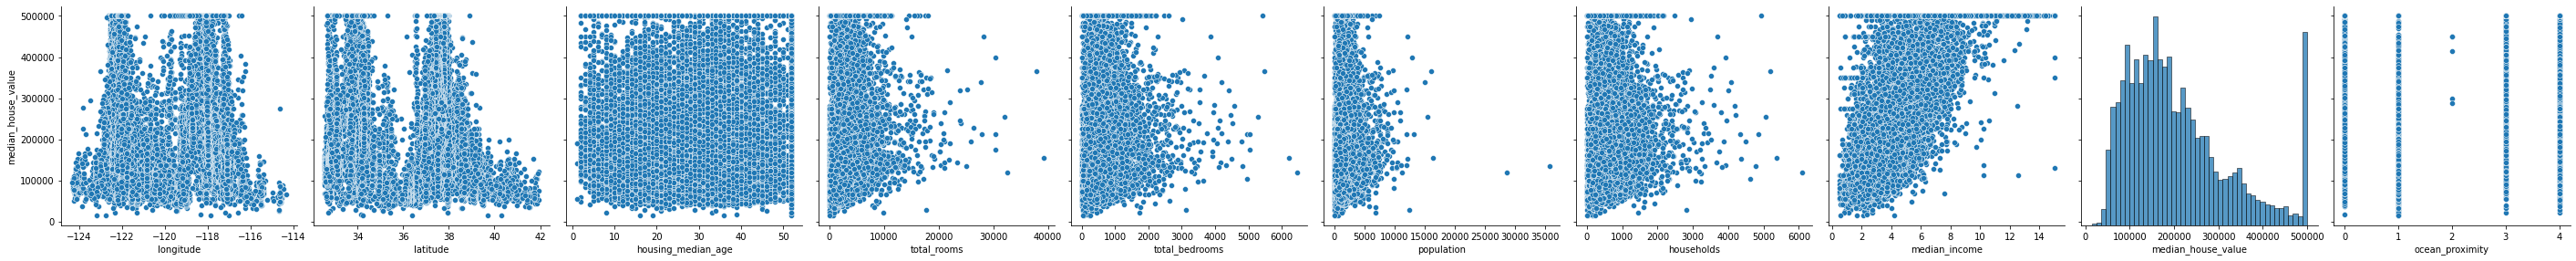

In [11]:
sb.pairplot(df,x_vars=df.columns,y_vars='median_house_value',height=4)

Heatmap of correlations

<AxesSubplot:>

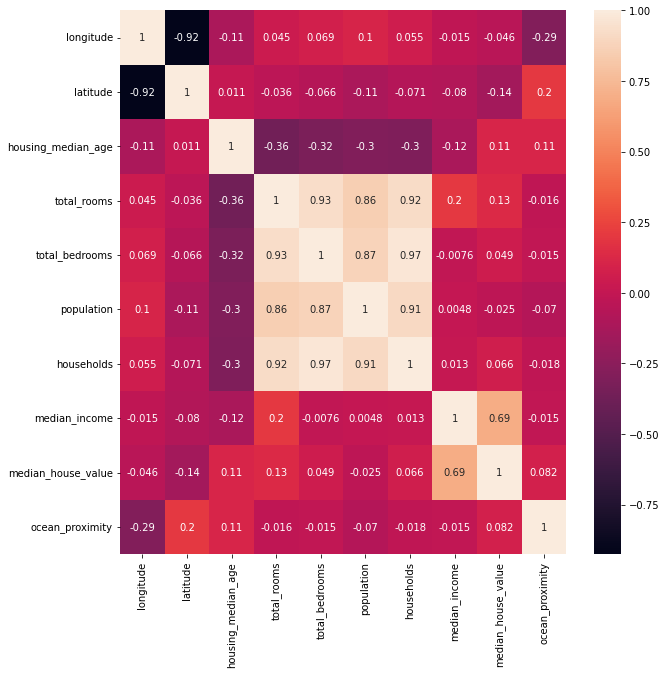

In [12]:
plt.figure(figsize=(10,10))
sb.heatmap(df.corr(),annot=True)

From pairplot and heatmap, all independent variables except median_income have a weak linear relationship with median_house_value. Hence, a linear regression model would not be an optimal model.

In [13]:
from sklearn.linear_model import LinearRegression
#Linear regression with all the features
lm = LinearRegression().fit(x_train,y_train)
#R-squared value of model on train data
lm.score(x_train,y_train)

0.6396424977490676

r-squared value: 0.6230404445060108


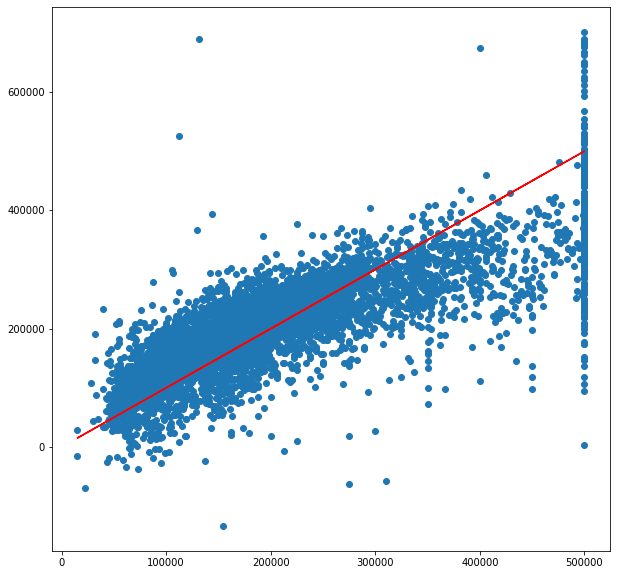

In [14]:
#Using model to predict prices of test data
pred = lm.predict(x_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test,pred)
plt.plot(y_test,y_test,color='red')
print("r-squared value:",sklearn.metrics.r2_score(y_test,pred))

In [15]:
#Linear regression with the 4 independent variables with magnitude of correlation with median_house_value >0.1
lm1 = LinearRegression().fit(x_train[['latitude','housing_median_age','total_rooms','median_income']],y_train)
lm1.score(x_train[['latitude','housing_median_age','total_rooms','median_income']],y_train)

0.5270040323715797

r-squared value: 0.5050093180129148


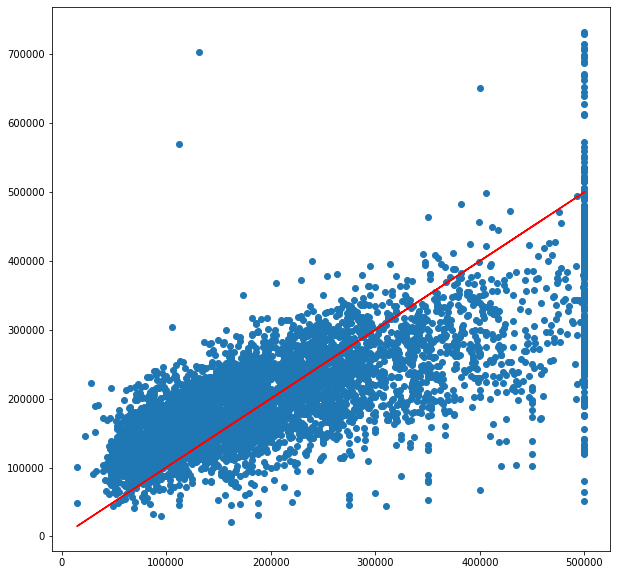

In [16]:
pred1 = lm1.predict(x_test[['latitude','housing_median_age','total_rooms','median_income']])
plt.figure(figsize=(10,10))
plt.scatter(y_test,pred1)
plt.plot(y_test,y_test,color='red')
print("r-squared value:",sklearn.metrics.r2_score(y_test,pred1))

#Decision Tree Regression

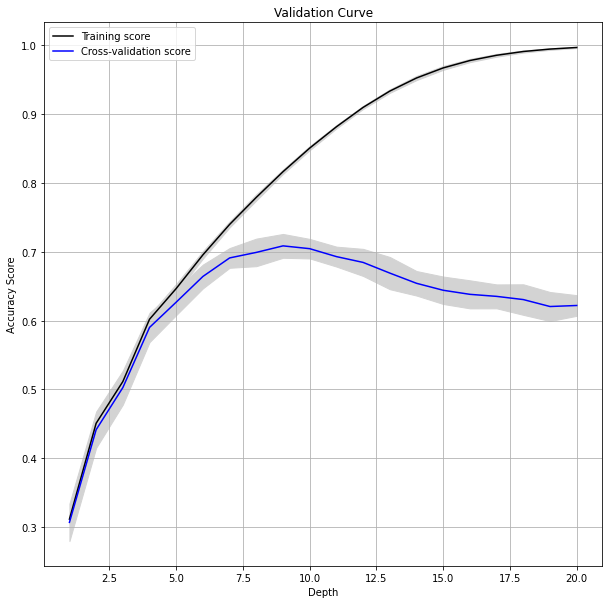

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import validation_curve

#Finding optimal depth with validation curve
param_range = range(0,21)
train_scores, test_scores = validation_curve(DecisionTreeRegressor(), x_train, y_train, param_name="max_depth", param_range=param_range)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,10))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="lightgray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="lightgray")
plt.title("Validation Curve")
plt.xlabel("Depth")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid()
plt.show()

Optimal depth with least underfitting and overfitting is 9.

In [33]:
dtr = DecisionTreeRegressor(random_state=0,max_depth=9)
dtr.fit(x_train,y_train)
dtr.score(x_train,y_train)

0.813020996513042

r-squared value: 0.719022355004263


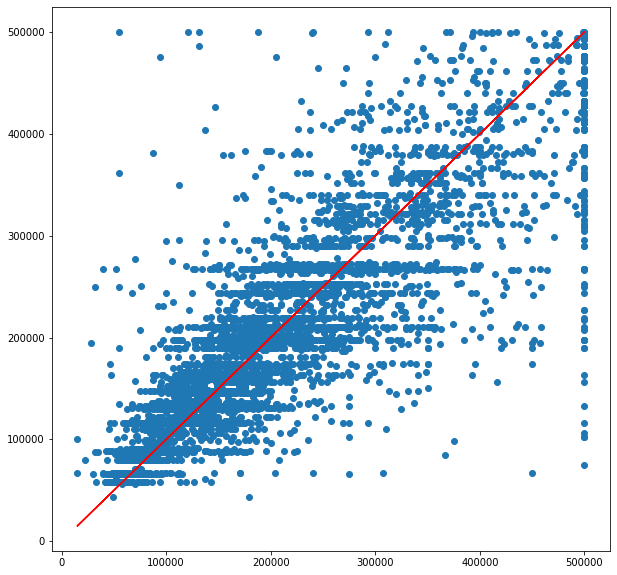

In [34]:
pred_dtr = dtr.predict(x_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test,pred_dtr)
plt.plot(y_test,y_test,color='red')
print("r-squared value:",sklearn.metrics.r2_score(y_test,pred_dtr))

#Random Forest Regression

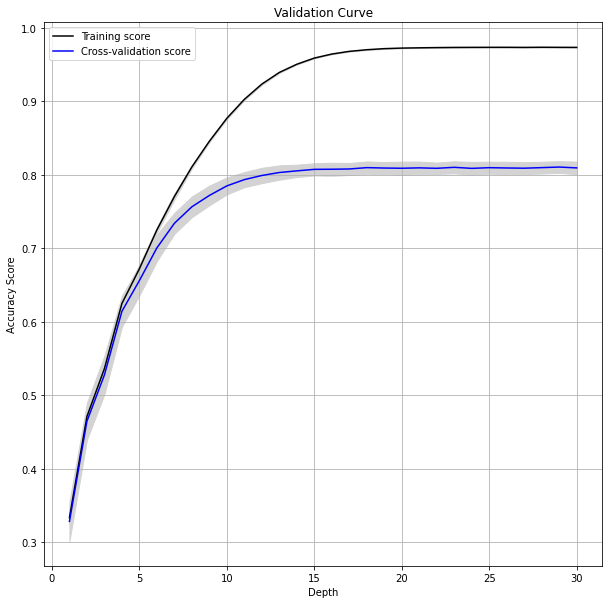

In [29]:
from sklearn.ensemble import RandomForestRegressor

#Finding optimal depth with validation curve
param_range = range(0,31)
train_scores, test_scores = validation_curve(RandomForestRegressor(), x_train, y_train, param_name="max_depth", param_range=param_range)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,10))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="lightgray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="lightgray")
plt.title("Validation Curve")
plt.xlabel("Depth")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid()
plt.show()

Depth of 25 seems to be a good depth without underfitting and overfitting.

In [41]:
rfr = RandomForestRegressor(random_state=0,max_depth=25)
rfr.fit(x_train,y_train)
rfr.score(x_train,y_train)

0.9740913933580543

r-squared value: 0.815149547344211


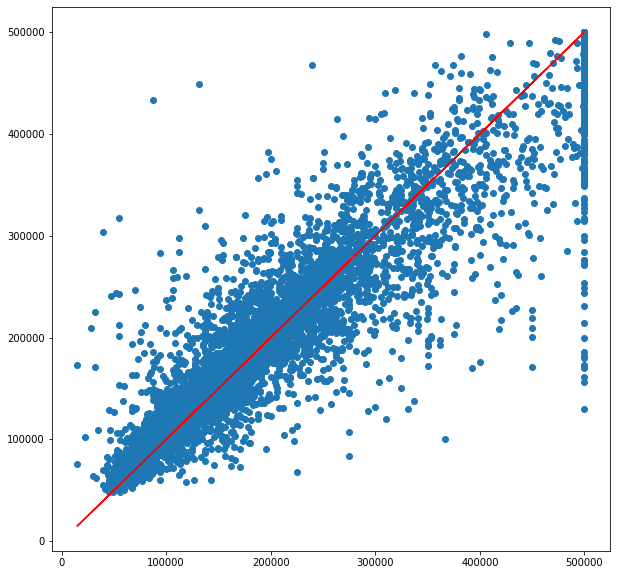

In [42]:
pred_rfr = rfr.predict(x_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test,pred_rfr)
plt.plot(y_test,y_test,color='red')
print("r-squared value:",sklearn.metrics.r2_score(y_test,pred_rfr))